In [1]:
from lib.dataset_utils import *
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import numpy as np
import string
import wordcloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
DATASET = DatasetEnum.TwitterDataCleaned
# load dataset
global_df = pd.concat(load_dataset(DATASET))
LABELS = global_df.columns[1:]
TEXT_COLUMN = 'text'
CLEAN_TEXT_COLUMN = 'clean_text'

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_content(text):
    
    # convert to lowercase
    clean_text = text.lower()

    # tokenize
    clean_text = nltk.word_tokenize(clean_text)
    
    # pos tag
    clean_text = nltk.pos_tag(clean_text)
    TAG_MAP = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    clean_text = [(word, TAG_MAP.get(tag[0], 'n')) for word, tag in clean_text]

    # lemmatize
    clean_text = [lemmatizer.lemmatize(word, tag) for word, tag in clean_text]

    # remove punctuation marks
    clean_text = [w for w in clean_text if w not in string.punctuation]

    return ' '.join(clean_text)

def clean_df(df, text_col, out_col):
    df[out_col] = df[text_col].apply(clean_content)
    return df

In [4]:
CLEAN_TEXT_COLUMN = 'clean_text'
global_df = clean_df(global_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)

In [5]:
# count words for each class
from collections import Counter
word_counter = {label: Counter() for label in LABELS}
global_prior = Counter()
for i, row in global_df.iterrows():
    for label in LABELS:
        if row[label] == 1:
            # remove duplicate tokens
            tokens = set(row[CLEAN_TEXT_COLUMN].split())
            word_counter[label].update(tokens)
            global_prior.update(tokens)

# get top 10 words for each class
top_words = {label: [word for word, _ in word_counter[label].most_common(10)] for label in LABELS}
print(top_words)

{'anger': ['i', 'feel', 'be', 'and', 'to', 'the', 'a', 'that', 'of', 'my'], 'fear': ['i', 'feel', 'be', 'and', 'to', 'a', 'the', 'of', 'my', 'that'], 'joy': ['i', 'feel', 'be', 'and', 'to', 'the', 'a', 'that', 'of', 'my'], 'love': ['i', 'feel', 'be', 'and', 'to', 'the', 'a', 'of', 'that', 'my'], 'sadness': ['i', 'feel', 'be', 'and', 'to', 'the', 'a', 'of', 'that', 'my'], 'surprise': ['i', 'feel', 'be', 'and', 'the', 'a', 'to', 'that', 'of', 'it']}


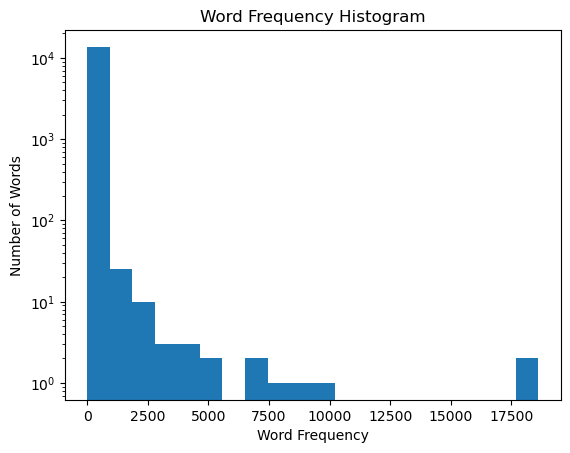

In [6]:
# plot word frequency hist of all words
plt.hist(global_prior.values(), bins=20, log=True)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.title('Word Frequency Histogram')
plt.show()

In [ ]:
# loglog plot
plt.loglog(np.arange(len(global_prior.values())), sorted(global_prior.values(), reverse=True))
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Word Frequency Rank Plot')
plt.show()

In [7]:
CUT_THRESHOLD = 5
# cut off words that are too rare based on global prior
to_remove = []
for word in list(global_prior):
    if global_prior[word] < CUT_THRESHOLD:
        to_remove.append(word)
        global_prior.pop(word)
for label in LABELS:
    for word in to_remove:
        if word in word_counter[label]:
            word_counter[label].pop(word)

In [8]:
len(to_remove)

10291

In [9]:
# get class probability
class_prob = {label: sum(global_df[label]) / len(global_df) for label in LABELS}

In [10]:
# get word list
vocab = set()
for label in LABELS:
    vocab.update(word_counter[label].keys())
vocab = list(vocab)

In [11]:
ALPHA = 0.9
K_SMOOTH = 0.01
pmi_matrix = np.zeros((len(vocab), len(LABELS)))
for i, word in enumerate(vocab):
    for j, label in enumerate(LABELS):
        pmi_matrix[i, j] = np.max(np.log2((word_counter[label][word] + K_SMOOTH) / np.power((global_prior[word] + K_SMOOTH), ALPHA) / class_prob[label]), 0)#TODO check

In [12]:
# get top 10 words for each class
top_words = {label: [vocab[i] for i in np.argsort(pmi_matrix[:, j])[-10:]] for j, label in enumerate(LABELS)}
for emotion in LABELS:
    print(emotion, top_words[emotion])

anger ['dissatisfy', 'violent', 'cranky', 'rebellious', 'envious', 'dangerous', 'bitchy', 'irritable', 'resentful', 'greedy']
fear ['distraught', 'unsure', 'skeptical', 'paranoid', 'uncertain', 'vulnerable', 'hesitant', 'reluctant', 'shaky', 'apprehensive']
joy ['smug', 'terrific', 'intelligent', 'virtuous', 'productive', 'clever', 'sincere', 'superior', 'festive', 'energetic']
love ['supportive', 'delicate', 'naughty', 'fond', 'gentle', 'nostalgic', 'horny', 'tender', 'loyal', 'sympathetic']
sadness ['homesick', 'dull', 'listless', 'punish', 'groggy', 'unwelcome', 'melancholy', 'inadequate', 'unimportant', 'gloomy']
surprise ['dazed', 'enthral', 'stunned', 'stun', 'amazed', 'shocked', 'impress', 'daze', 'impressed', 'curious']


Word cloud for anger


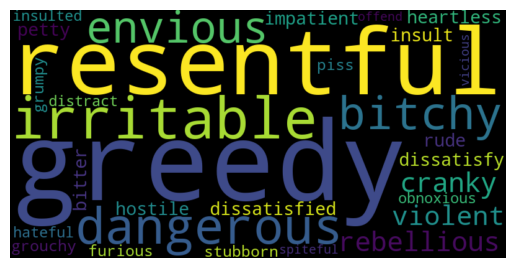

Word cloud for fear


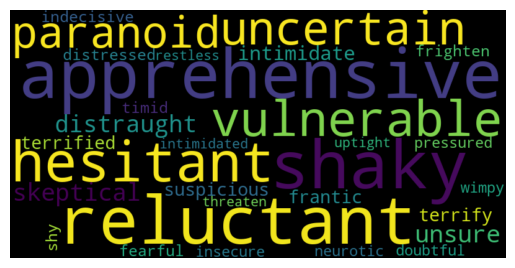

Word cloud for joy


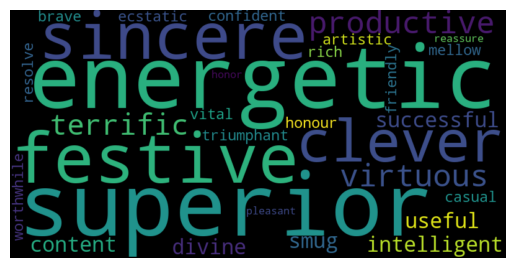

Word cloud for love


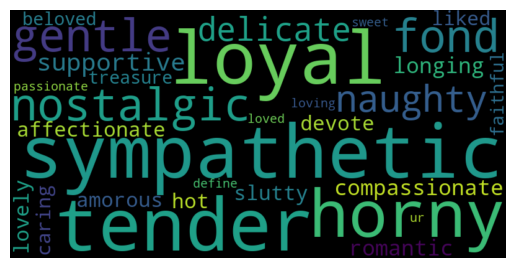

Word cloud for sadness


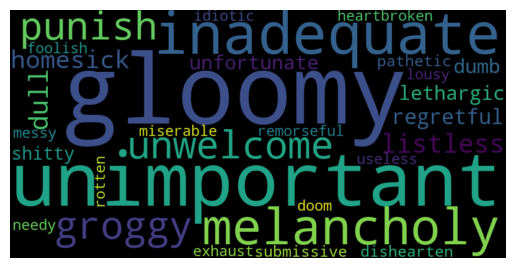

Word cloud for surprise


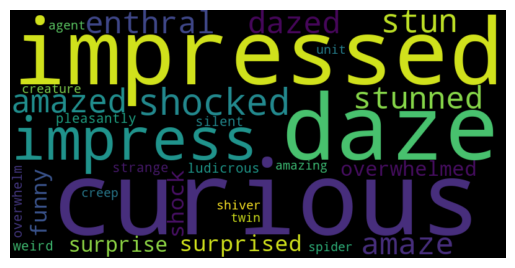

In [13]:
# word cloud of top words given scores
N_TOP = 30
for label in LABELS:
    print(f'Word cloud for {label}')
    wc = wordcloud.WordCloud(width=800, height=400, max_words=N_TOP).generate_from_frequencies({word: pmi_matrix[i, LABELS.get_loc(label)] for i, word in enumerate(vocab)})
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
RESULT_PATH = './results/GoEmotions/'
RESULT_FILE = RESULT_PATH + 'GoEmotions_emotions_words.csv'
# generate dataframe of scores
score_df = pd.DataFrame(pmi_matrix, index=vocab, columns=LABELS)
score_df.to_csv(RESULT_FILE)